# Speech Recognition with QuartzNet

This notebook uses [QuartzNet](https://arxiv.org/abs/1910.10261) from the open source project [NVIDIA/NeMo](https://github.com/NVIDIA/NeMo) to transcribe a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install NVIDIA/QuartzNet

In [0]:
#@title
import os
from os.path import exists, join, basename, splitext
from IPython.display import YouTubeVideo

!pip -q install wget youtube-dl wget tensorboardX kaldi-io marshmallow num2words ruamel.yaml soundfile sox torch-stft unidecode
!pip install -q nemo-toolkit==0.9.0 nemo-asr==0.9.0 #--no-deps

# we need also Apex
if not exists('apex'):
  !git clone -q --depth 1 https://github.com/NVIDIA/apex
  !cd apex && pip install -q --no-cache-dir ./

## Download pretrained weights

In [0]:
#@title
if not exists('quartznet15x5_multidataset'):
  # download the pretrained weights
  !wget -nc -q --show-progress -O quartznet15x5.zip https://api.ngc.nvidia.com/v2/models/nvidia/multidataset_quartznet15x5/versions/1/zip
  !unzip quartznet15x5.zip && mkdir quartznet15x5_multidataset && mv Jasper* quartznet15x5.yaml quartznet15x5_multidataset

## Initialize QuartzNet

In [0]:
#@title
#
# this code is copied and modified from the NVIDIA/NeMo repo.
#

import json
from ruamel.yaml import YAML
import nemo
import nemo_asr

WORK_DIR = "/content/quartznet15x5_multidataset"
MODEL_YAML = "/content/quartznet15x5_multidataset/quartznet15x5.yaml"
CHECKPOINT_ENCODER = "/content/quartznet15x5_multidataset/JasperEncoder-STEP-243800.pt"
CHECKPOINT_DECODER = "/content/quartznet15x5_multidataset/JasperDecoderForCTC-STEP-243800.pt"
# Set this to True to enable beam search decoder
ENABLE_NGRAM = False
# This is only necessary if ENABLE_NGRAM = True. Otherwise, set to empty string
LM_PATH = "<PATH_TO_KENLM_BINARY>"

# Read model YAML
yaml = YAML(typ="safe")
with open(MODEL_YAML) as f:
    jasper_model_definition = yaml.load(f)
labels = jasper_model_definition['labels']

# Instantiate necessary Neural Modules
# Note that data layer is missing from here
neural_factory = nemo.core.NeuralModuleFactory(
    placement=nemo.core.DeviceType.GPU,
    backend=nemo.core.Backend.PyTorch)
data_preprocessor = nemo_asr.AudioToMelSpectrogramPreprocessor(factory=neural_factory)
jasper_encoder = nemo_asr.JasperEncoder(
    jasper=jasper_model_definition['JasperEncoder']['jasper'],
    activation=jasper_model_definition['JasperEncoder']['activation'],
    feat_in=jasper_model_definition['AudioToMelSpectrogramPreprocessor']['features'])
jasper_encoder.restore_from(CHECKPOINT_ENCODER, local_rank=0)
jasper_decoder = nemo_asr.JasperDecoderForCTC(
    feat_in=1024,
    num_classes=len(labels))
jasper_decoder.restore_from(CHECKPOINT_DECODER, local_rank=0)
greedy_decoder = nemo_asr.GreedyCTCDecoder()

def wav_to_text(manifest, greedy=True):
    from ruamel.yaml import YAML
    yaml = YAML(typ="safe")
    with open(MODEL_YAML) as f:
        jasper_model_definition = yaml.load(f)
    labels = jasper_model_definition['labels']

    # Instantiate necessary neural modules
    data_layer = nemo_asr.AudioToTextDataLayer(
        shuffle=False,
        manifest_filepath=manifest,
        labels=labels, batch_size=1)

    # Define inference DAG
    audio_signal, audio_signal_len, _, _ = data_layer()
    processed_signal, processed_signal_len = data_preprocessor(
        input_signal=audio_signal,
        length=audio_signal_len)
    encoded, encoded_len = jasper_encoder(audio_signal=processed_signal,
                                          length=processed_signal_len)
    log_probs = jasper_decoder(encoder_output=encoded)
    predictions = greedy_decoder(log_probs=log_probs)

    if ENABLE_NGRAM:
        print('Running with beam search')
        beam_predictions = beam_search_with_lm(
            log_probs=log_probs, log_probs_length=encoded_len)
        eval_tensors = [beam_predictions]

    if greedy:
        eval_tensors = [predictions]

    tensors = neural_factory.infer(tensors=eval_tensors)
    if greedy:
        from nemo_asr.helpers import post_process_predictions
        prediction = post_process_predictions(tensors[0], labels)
    else:
        prediction = tensors[0][0][0][0][1]
    return prediction

def create_manifest(file_path):
    # create manifest
    manifest = dict()
    manifest['audio_filepath'] = file_path
    manifest['duration'] = 18000
    manifest['text'] = 'todo'
    with open(file_path+".json", 'w') as fout:
        fout.write(json.dumps(manifest))
    return file_path+".json"

## Transcribe Youtube Video

We are going to make speech recognition on the following youtube video:

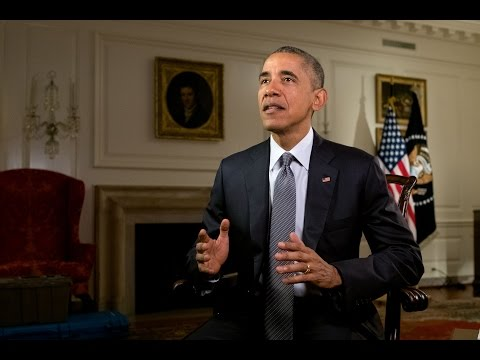

In [4]:
#@title
YOUTUBE_ID = '2AFpAATHXtc'


YouTubeVideo(YOUTUBE_ID)

Download the above video, convert to a WAV file and do speech recognition with a language model:

In [5]:
#@title
!rm -rf *.wav
!youtube-dl --extract-audio --audio-format wav --quiet --output "downloaded.%(ext)s" https://www.youtube.com/watch\?v\={YOUTUBE_ID}
!ffmpeg -loglevel panic -y -i downloaded.wav -acodec pcm_s16le -ac 1 -ar 16000 test.wav

transcription = wav_to_text(create_manifest('test.wav'))

print('\n\n')
print(transcription)

2020-04-13 14:25:08,253 - INFO - Dataset loaded with 5.00 hours. Filtered 0.00 hours.
2020-04-13 14:25:08,290 - INFO - Evaluating batch 0 out of 1





["hi verybody in our house everybody knows that president is only the third most important job in the family so this week i i'm going to take a little extra time to say thank you to michel for the remarkable way she does the most important job being a mam and am going to give extra thanks to my mother in law for the role model he's always been to michele in the countless selfless ways in which she's helped wi shewing me raise moly ansasha i am incredibly lucky to have these wonderful women help me raise love and look after our girls i hope you'll also take a moment to say thank you to the women in your life who love you in that special way mom's do bi logical moms medoptive moms and foster mops single moms grandmas godmothers aunts mentors whomever you think of when you think of mother's day or take a moment like i will to remember the moms who raised us whose big hearts sustained us and whom we miss every day no matter how old we get giving flowers is always a good idea but i hope 